## Try XGBOOST as Forecats model for Crypto prediction

In [1]:
import numpy as np
from math import sqrt
import pandas as pd

import sklearn 
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.feature_selection import SelectFromModel
import xgboost
from xgboost import XGBRegressor

from matplotlib import pyplot as plt
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
#from torch import nn, optim
#import torch

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
#torch.manual_seed(RANDOM_SEED)


In [2]:
#from google.colab import drive
#drive.mount('/drive', force_remount=True)

In [3]:
#data=pd.read_csv('/drive/My Drive/Anna_Jayni_collaboration/code/data/ETH_histical_data.csv')
coin='BTC'
#data=pd.read_csv(f'/drive/My Drive/Anna_Jayni_collaboration/code/data/{coin}_historical.csv')
data=pd.read_csv(f'data/{coin}_historical.csv')
##remove the first unreliable records for DOT
data=data.iloc[14:]
print(f'Dataset of crypto {coin} has {data.shape[0]} features and {data.shape[0]} historical values')
print(f'Data is collected from {str(data.date.min())} to {str(data.date.max())}')


Dataset of crypto BTC has 351 features and 351 historical values
Data is collected from 2020-11-16 to 2021-11-01


### Transform dataset for supervised learning
### Train model using all features
### Find the most important features
### Predict

Create lagged features to the target variable and exogenous features

*   lag features: they use the original time series itself as a feature with a certain shift usually called lag. Lags can be chosen automatically looking at the values of the partial autocorrelation function. As we target on feature selection as a part of the model be can generate at least 14, ..30 or more of them depending on forecast horizon
*   exogenous features: exogenous features are themselves time series and are external, i.e. they do not depend on the time series to be forecast. In our case, an exogenous variables are other features that are collected through API
* lag exogenous features: the exogenous variables with some lag to proof or disproof the impact on the target variable







Historical data of close value


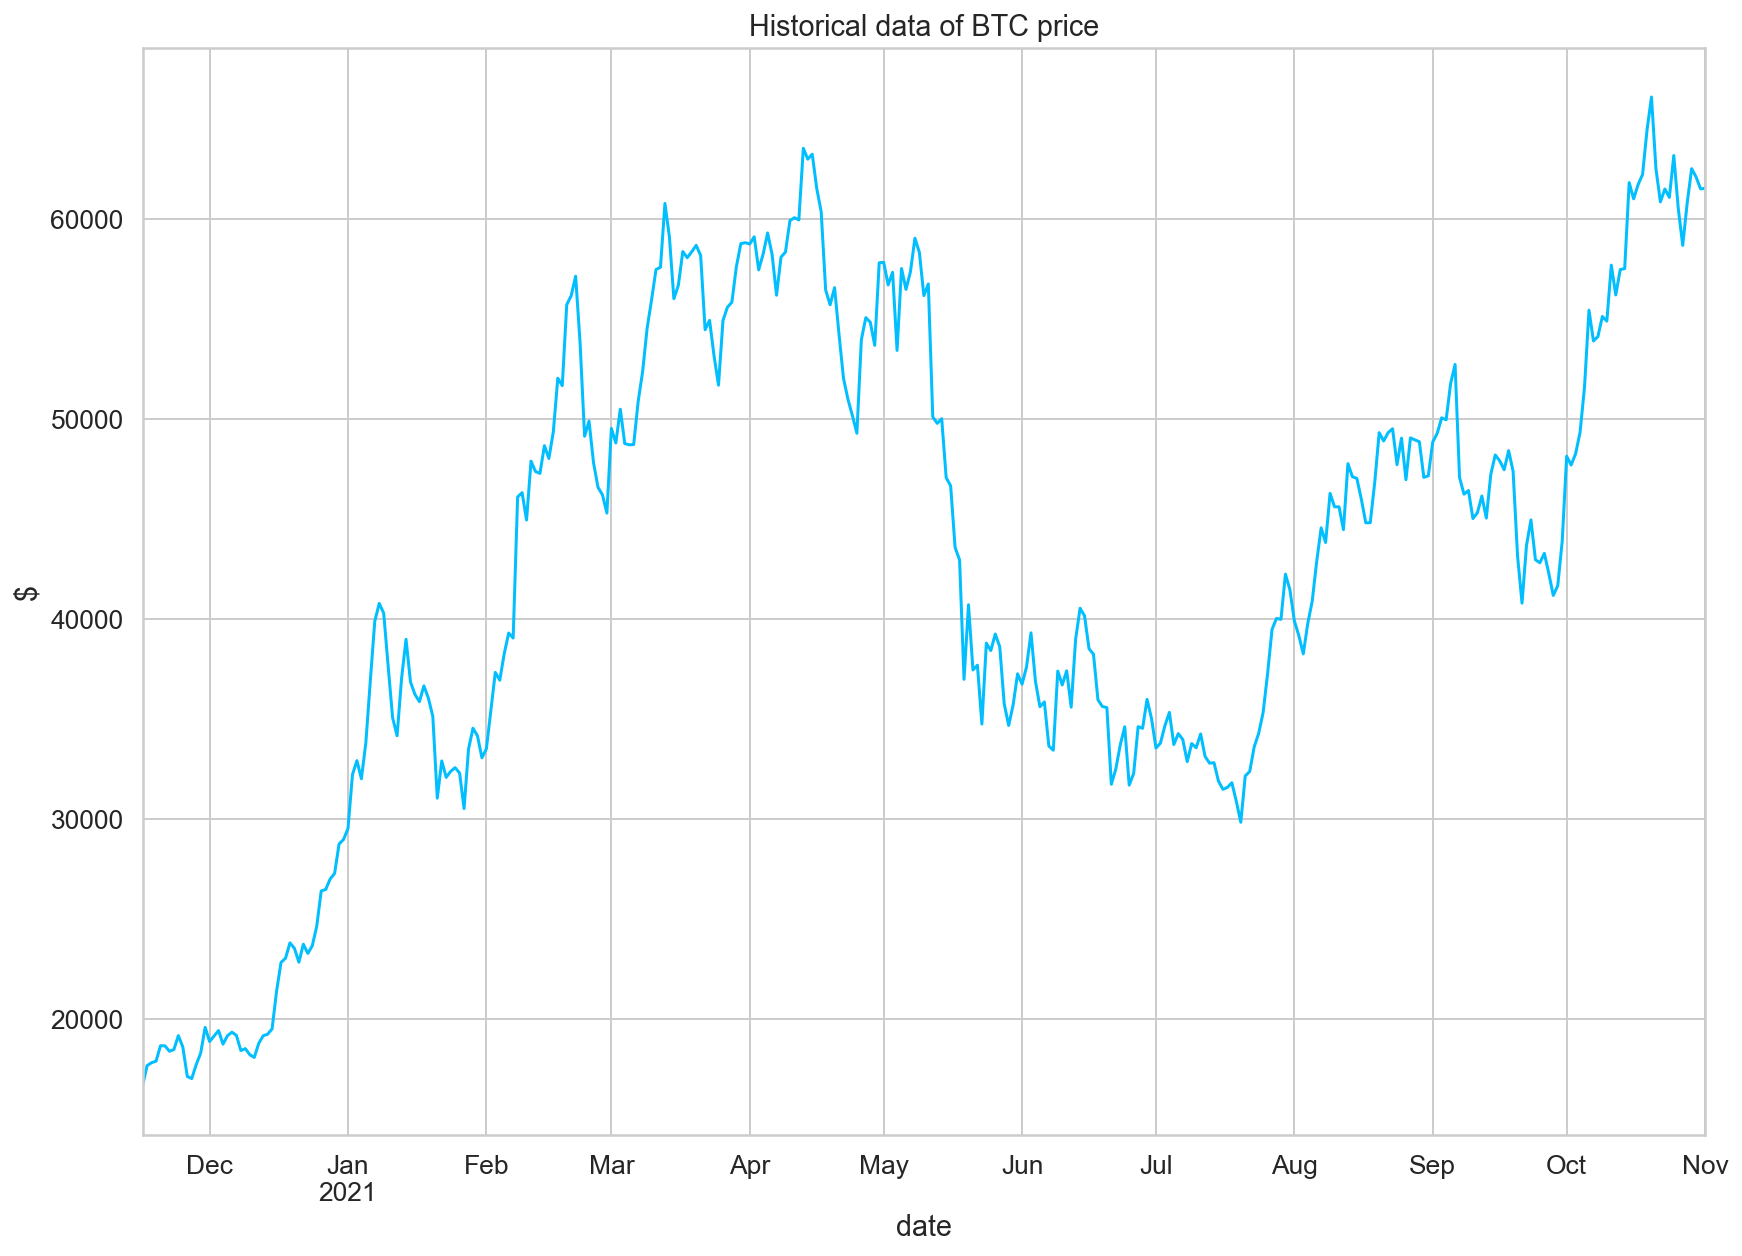

In [4]:
#Data preparation
#Remove the columns that contains a lot of nan values
nan_stat= (data.isnull().sum())
for col_name, val in nan_stat.items():
    if val>data.shape[0]*0.2:
        data.drop(columns=[col_name], inplace=True)

#remove highly correlated columns
data.drop(columns=['open', 'high', 'low'], inplace=True)
set_columns=[cc for cc in data.columns if cc!='date']
#select target feature
target_column='close'
#fill in missing values
df=data[set_columns].fillna(method='ffill').fillna(0)
df.index=pd.DatetimeIndex(data.date)
#get target vector
target=data[target_column]
print(f'Historical data of {target_column} value')
pd.Series(data[target_column].values, index=pd.DatetimeIndex(data.date)).plot(title=f'Historical data of {coin} price')
plt.ylabel('$')
plt.show()

In [5]:
from functions.prep_data import *

Number of features in Original dataset 54
Target of prediction close
Total Number of generated features 1728
Examples of generated feature names
Index(['close-31', 'volume-31', 'market_cap-31', 'url_shares-31',
       'unique_url_shares-31', 'reddit_posts-31', 'reddit_posts_score-31',
       'reddit_comments-31', 'reddit_comments_score-31', 'tweets-31',
       'tweet_spam-31', 'tweet_followers-31', 'tweet_quotes-31',
       'tweet_retweets-31', 'tweet_replies-31', 'tweet_favorites-31',
       'tweet_sentiment1-31', 'tweet_sentiment2-31', 'tweet_sentiment3-31',
       'tweet_sentiment4-31', 'tweet_sentiment5-31',
       'tweet_sentiment_impact1-31', 'tweet_sentiment_impact2-31',
       'tweet_sentiment_impact3-31', 'tweet_sentiment_impact4-31',
       'tweet_sentiment_impact5-31', 'social_score-31', 'average_sentiment-31',
       'sentiment_absolute-31', 'sentiment_relative-31', 'news-31',
       'price_score-31', 'social_impact_score-31', 'correlation_rank-31',
       'galaxy_score-31'

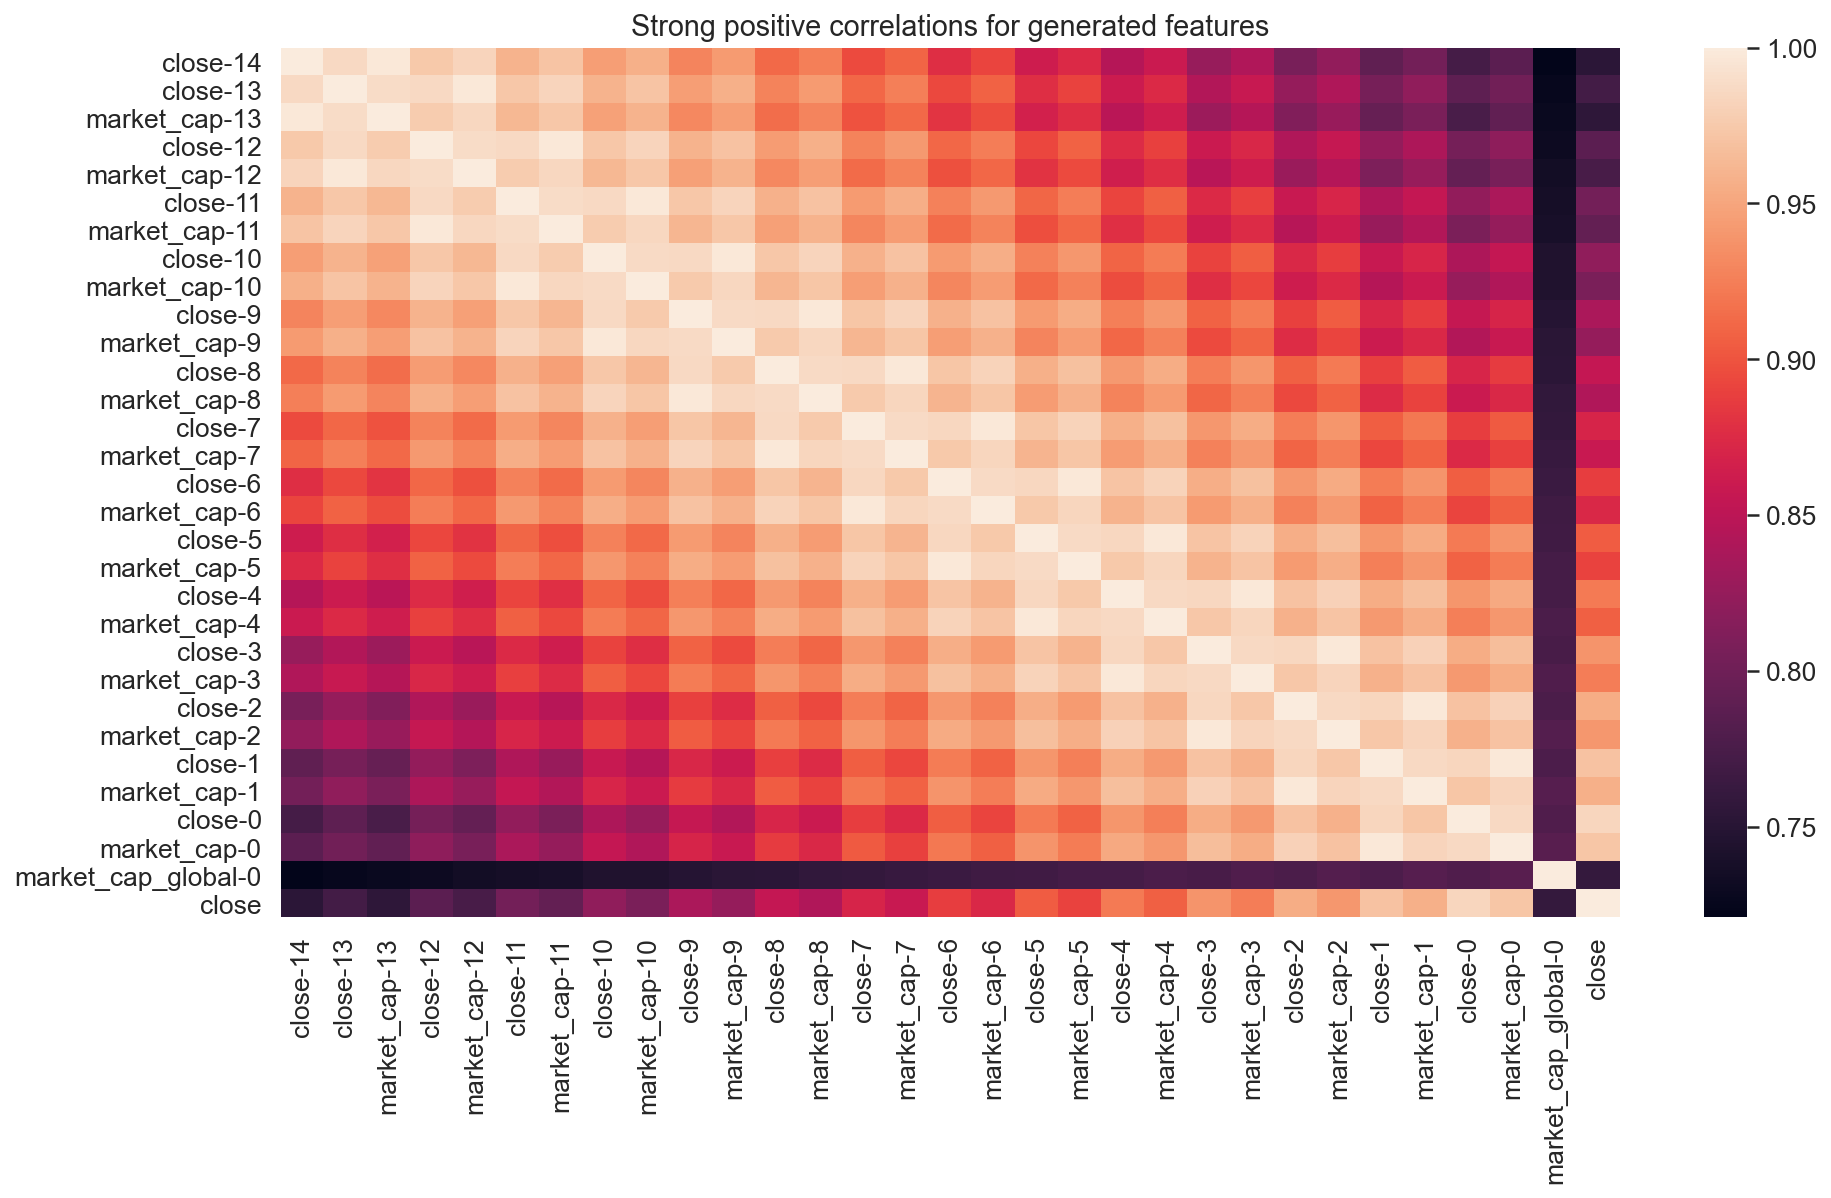

Input dataset is build using last 31 days of historical data for 1 day ahead
3 features are selected based on the threshold of importance
['close-0', 'market_cap-0', 'close-16']


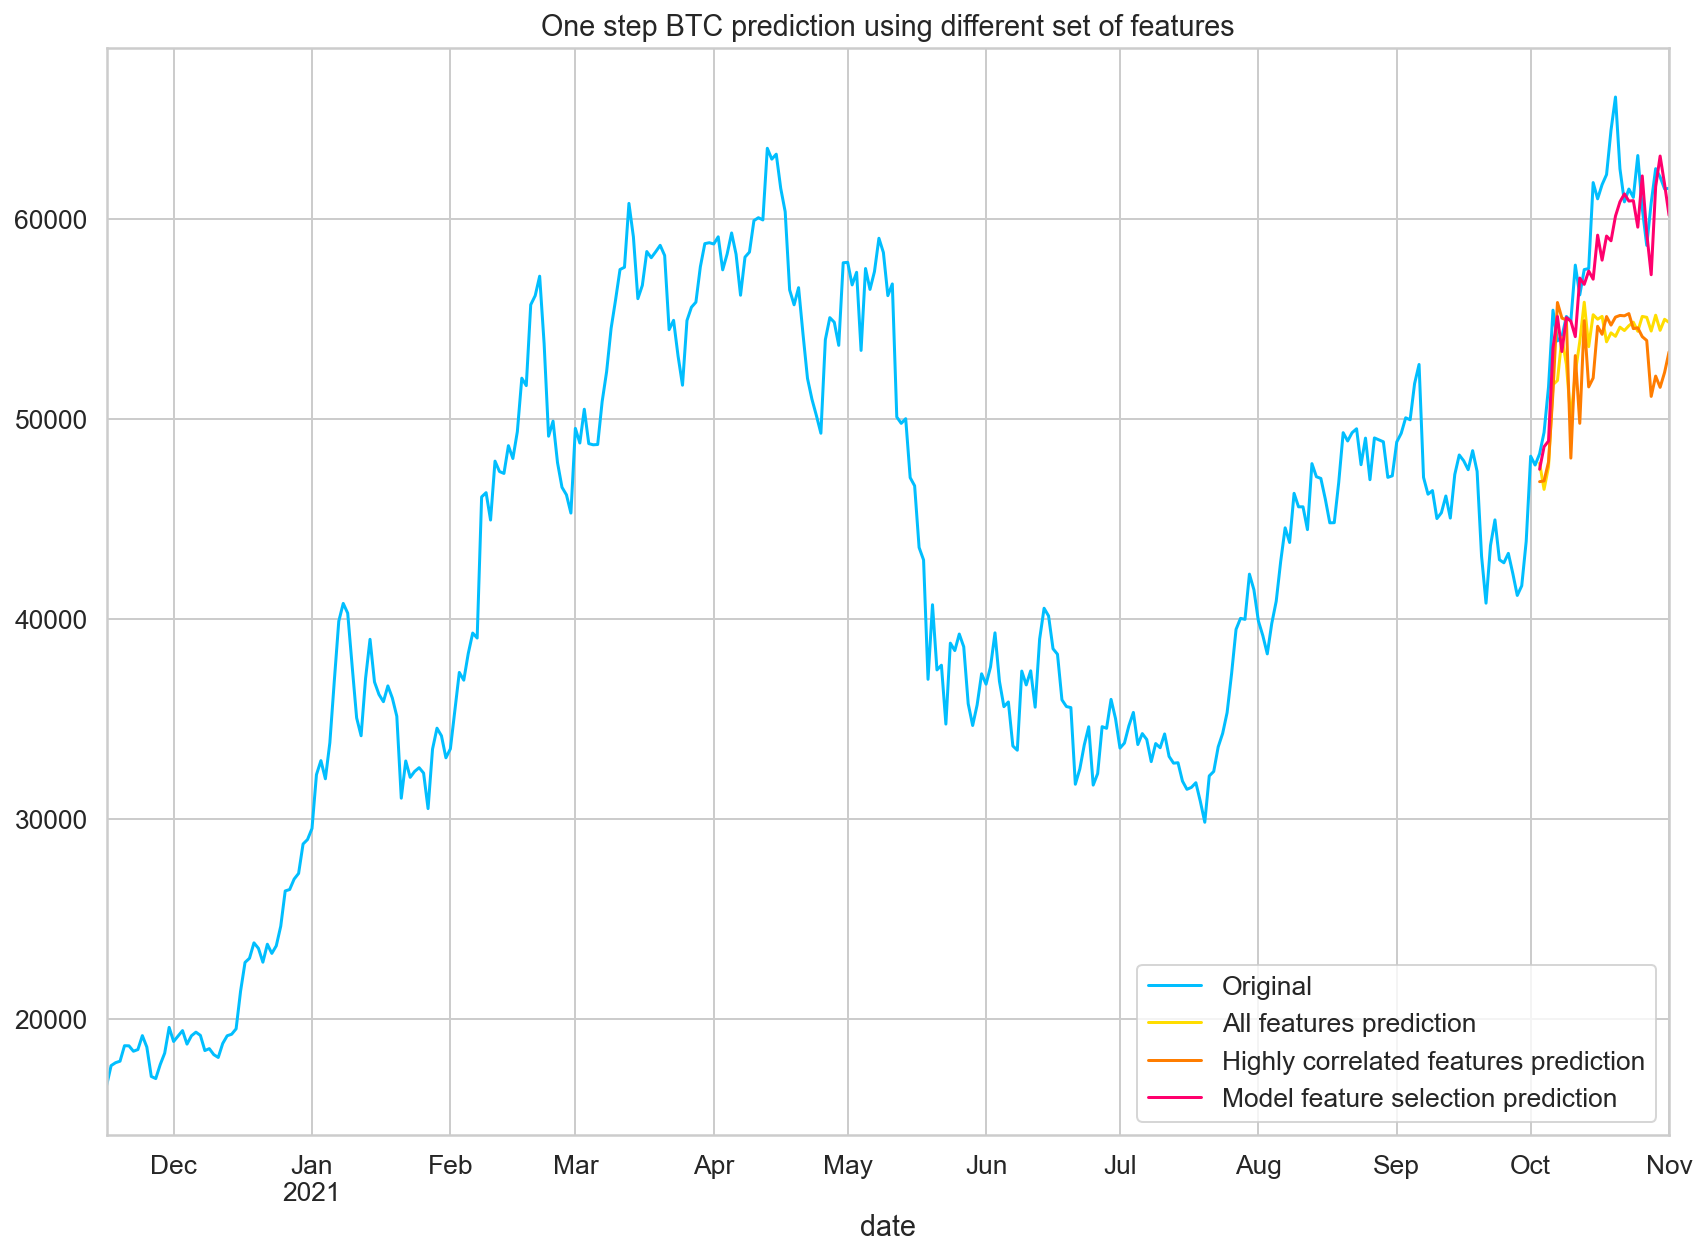

Models comparison using MAE and MAPE


,MAE,MAPE
All features,5437.0,10.45
Highly correlated features,6196.0,11.21
Model selected features,1804.0,8.22


In [7]:

#Run transformation to dataset for supervised learning
#n_in - number of historical lags to include in forecast
#n_out - number of lags predicted in future
#for example we want to predict 7 days in the future using history of last two weeks
#n_out=7, n_in=14
n_in=31
n_out=1
#get target vector
target=df[target_column]
set_columns_list=', '.join(set_columns)

print(f'Number of features in Original dataset {len(set_columns)}')
print(f'Target of prediction {target_column}')

#Transform dataframe for supervised learning
res=lagged_features(df, target, n_in=n_in, n_out=n_out, dropnan=True)
print(f'Total Number of generated features {len(res.columns)-1}')
print(f'Examples of generated feature names')
print(res.columns[:35])

# calculate the correlation matrix
corr = res.corr()
#Get strong positive correlations
pos_corr=corr[corr['close']>0.75][corr[corr['close']>0.75].index.values]

# plot the heatmap
plt.figure(figsize=[15,8])
sns.heatmap(pos_corr, 
        xticklabels=pos_corr.columns,
        yticklabels=pos_corr.columns)
plt.title('Strong positive correlations for generated features')
plt.show()
corr_features=pos_corr.columns

print(f'Input dataset is build using last {n_in} days of historical data for {n_out} day ahead')
#build xgboost prediction model
#Use the data with lag to predict the value in number of N_pred values in n_out steps
N_pred=30
train, test=res[:-N_pred], res[-N_pred:]
trainX, testX=np.array(train[[cc for cc in train.columns if cc!=target_column]]), np.array(test[[cc for cc in train.columns if cc!=target_column]])
trainy, testy=res[[target_column]][:-N_pred],res[[target_column]][-N_pred:]

# fit model with all features
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(trainX, trainy)
# make a prediction for test dataset
yhat = model.predict(np.asarray(testX))
#calculate errors
def prediction_errors(testy, yhat):
    return mean_absolute_error(testy, yhat), mean_absolute_percentage_error(testy, yhat)
mae_all_features,mape_all_features =prediction_errors(testy, yhat)

#Plot the results
index_pred=df.index.values[-N_pred:]
yhat=pd.Series(yhat, index=index_pred)
#df.loc[index_pred]['close'].plot(label='original')
df['close'].plot(label='Original')
yhat.plot(label='All features prediction')

#Build prediction model using highly correlated features only
trainX_corr, testX_corr=np.array(train[[cc for cc in corr_features if cc!=target_column]]), np.array(test[[cc for cc in corr_features if cc!=target_column]])
model_corr = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model_corr.fit(trainX_corr, trainy)
yhat_corr = model_corr.predict(np.asarray(testX_corr))
yhat_corr=pd.Series(yhat_corr, index=index_pred)
yhat_corr.plot(label='Highly correlated features prediction')
mae_correlated_features,mape_correlated_features =prediction_errors(testy, yhat_corr)

## Check if the error can be decreased using sklearn feature importance with different threshholds 
feature_factor=get_N_features_dict(model, trainX, trainy, testX, testy,verbose=False)
features=features_importance_top_N(model, train[[cc for cc in train.columns if cc!=target_column]], topN=min(feature_factor, key=feature_factor.get))
print(f'{len(features)} features are selected based on the threshold of importance')
print(features)
#Train and test on the most valuable features only
## Train and test model with selected features only
trainX_feat, testX_feat=train_test_split(res[features].values, N_pred) 
# fit model
modelf = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
modelf.fit(trainX_feat, trainy)
# make a prediction for test dataset
yhat_feat = modelf.predict(np.asarray(testX_feat))
#Plot the results
yhat_feat=pd.Series(yhat_feat, index=index_pred)
yhat_feat.plot(label='Model feature selection prediction')
mae_selected_features,mape_selected_features =prediction_errors(testy, yhat_feat)

plt.legend()
plt.title(f'One step {coin} prediction using different set of features')
plt.show()

print('Models comparison using MAE and MAPE')
error_comparison=pd.DataFrame({'MAE':[np.round(mae_all_features),np.round(mae_correlated_features),np.round(mae_selected_features) ], 
                               'MAPE':[np.round(mape_all_features,2), np.round(mape_correlated_features,2), np.round(mape_selected_features,2)]}, 
                              index=['All features','Highly correlated features', 'Model selected features'])
error_comparison


In [ ]:
#error_comparison=pd.DataFrame({'MAE':[np.round(mae_all_features,3),np.round(mae_correlated_features,3),np.round(mae_selected_features,3) ], 
#                               'MAPE':[np.round(mape_all_features,3), np.round(mape_correlated_features,3), np.round(mape_selected_features,3)]}, 
#                              index=['All features','Highly correlated features', 'Model selected features'])
#error_comparison


### Trying with RandomizedSearchCV and GradientBoostingRegressor

In [ ]:

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
gb = RandomizedSearchCV(GradientBoostingRegressor(),
param_distributions =  {
               'n_estimators':np.arange(10,500,5),
               'max_features':np.arange(1,10,1)
            },
          cv=5, n_iter = 20, random_state=0,refit=True, scoring="neg_mean_absolute_error")
gb.fit(trainX, trainy.values.ravel())
print(gb.best_params_)
yhat_gb=gb.predict(testX)
yhat_gb=pd.Series(yhat_gb, index=index_pred)
testy.plot(label='Original')
yhat_gb.plot(label='GB grid search prediction')
plt.legend()
plt.show()
mae_all_gb,mape_all_gb  =prediction_errors(testy, yhat_gb)
error_comparison=pd.DataFrame({'MAE':[np.round(mae_all_gb,3) ], 
                               'MAPE':[np.round(mape_all_gb,3)]}, 
                              index=['RandomizedSearchCV selection'])
error_comparison

### Trying with RandomizedSearchCV and NeuralNets

In [ ]:
#Using all features
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(trainX)
nnet = RandomizedSearchCV(MLPRegressor(max_iter=5000,learning_rate = 'adaptive',solver='sgd'),
param_distributions =  {
     'hidden_layer_sizes':[(x,) for x in np.arange(1,50,1)],
     'activation':['logistic','relu']
},
cv=5, n_iter = 20,
random_state=0,refit=True,
scoring="neg_mean_absolute_error")
nnet.fit(scaler.fit_transform(trainX), trainy.values.ravel())
print(nnet.best_params_)
yhat_nnet=nnet.predict(scaler.fit_transform(testX))
yhat_nnet=pd.Series(yhat_nnet, index=index_pred)
testy.plot(label='GB grid search original')
yhat_nnet.plot(label='Nnet prediction')
plt.legend()
plt.show()

mae_all_nnet,mape_all_nnet  =prediction_errors(testy, yhat_nnet)
error_comparison=pd.DataFrame({'MAE':[np.round(mae_all_nnet,3) ], 
                               'MAPE':[np.round(mape_all_nnet,3)]}, 
                              index=['RandomizedSearchCV selection'])
error_comparison

In [ ]:
#Use only most impactful features only
nnet.predict(scaler.fit_transform(testX))
scaler = MinMaxScaler()
scaler.fit(trainX_feat)
nnet = RandomizedSearchCV(MLPRegressor(max_iter=5000,learning_rate = 'adaptive',solver='sgd'),
param_distributions =  {
     'hidden_layer_sizes':[(x,) for x in np.arange(1,50,1)],
     'activation':['logistic','relu']
},
cv=5, n_iter = 20,
random_state=0,refit=True,
scoring="neg_mean_absolute_error",return_train_score=True)
nnet.fit(scaler.fit_transform(trainX_feat), trainy.values.ravel())
print(nnet.best_params_)
yhat_nnet=nnet.predict(scaler.fit_transform(testX_feat))
yhat_nnet=pd.Series(yhat_nnet, index=index_pred)
testy.plot(label='GB grid search original')
yhat_nnet.plot(label='Nnet prediction')
plt.legend()
plt.show()
mae_all_nnet,mape_all_nnet  =prediction_errors(testy, yhat_nnet)
error_comparison=pd.DataFrame({'MAE':[np.round(mae_all_nnet,3) ], 
                               'MAPE':[np.round(mape_all_nnet,3)]}, 
                              index=['RandomizedSearchCV selection'])
error_comparison

# Recursive forecast strategy

Since recursive forecst including many features and target one leads to error accumulation as each time we need to predi ct to all of them to make a next step, we'll use only one feature which is lagged target value to build a model. Also we'll include some additional features that do not require prediction like 'day of week', month, day of month



---
 More about forecast strategies https://dzone.com/articles/lessons-learnt-while-solving-time-series-forecasti-1


In [ ]:

#Use 30 laggs to predict 1 step ahead
n_in=30
n_out=1
target_column='close'
target=df[target_column]
#generate lagged features
res=lagged_features(df[['close']], target, n_in=n_in, n_out=n_out, dropnan=True)
#add calendar features
res['day_of_week']=res.index.dayofweek
res['day_of_year']=res.index.dayofyear
res['month']=res.index.month
res['day']=res.index.day
print(f'Generated features '+', '.join(res.columns))
#build xgboost prediction model
#Test, train split
N_pred=30
train, test=res[:-N_pred], res[-N_pred:]
trainX, testX=np.array(train[[cc for cc in train.columns if cc!=target_column]]), np.array(test[[cc for cc in train.columns if cc!=target_column]])
trainy_, testy_=res[[target_column]][:-N_pred],res[[target_column]][-N_pred:]

model = XGBRegressor(objective='reg:squarederror', n_estimators=1000) # fit model
model.fit(trainX, trainy_)
yhat = model.predict(np.asarray(testX)) # make a prediction for test dataset
print(f'MAE of model for {n_out} step forecast with all features is {mean_absolute_error(testy, yhat)}')

#Select the fetures that have the biggest impact
feature_factor=get_N_features_dict(model,trainX,trainy_,testX, testy_, verbose=False)
print('List of selected features based on the selected threshold of importance')
features=features_importance_top_N(model,train[[cc for cc in train.columns if cc!=target_column]], topN=min(feature_factor, key=feature_factor.get))
print(features)

#Train and test on the most valuable features only
## Train and test model with selected features only
trainX_feat, testX_feat=np.array(train[features]), np.array(test[features]), 
modelf = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
modelf.fit(trainX_feat, trainy_)
# make a prediction for test dataset
yhat_feat = modelf.predict(np.asarray(testX_feat))
print(f'MAE selected features only {mean_absolute_error(testy, yhat_feat)}')
print(f'MAPE selected features only {mean_absolute_percentage_error(testy, yhat_feat)}')
print(f'RMSE selected features only {sqrt(mean_squared_error(testy, yhat_feat))}')
#Plot the results
index_pred=df.index.values[-N_pred:]
yhat_df_all=pd.Series(yhat, index=index_pred)
yhat_df_all.plot(label='prediction with all features')
yhat_df=pd.Series(yhat_feat, index=index_pred)
yhat_df.plot(label='prediction with selected features')
#pd.Series(testy, index=index_pred).plot(label='expected')
df.loc[index_pred]['close'].plot(label='Original')
plt.legend()
plt.title(f'{n_out} step prediction ')
plt.show()


In [ ]:
import datetime
#Apply recursive strategy to predict for 14 and 30 days

def pred_one_step(modelf, new_train, features,lagged_columns):
  """
    Parameters
    ---------
    modelf - XGboost model used for prediction
    new_train - datasets with all features to make a prediction
    lagged_columns - all lagged features required for prediction model
  """
  model_features=np.asarray(new_train[features])
  yhat = modelf.predict(model_features)
  new_df=pd.DataFrame(columns=features, index=[res.index[-1]+datetime.timedelta( 1)])
  new_test=dict()
  for feat in lagged_columns:
    if feat=='close-0':
      new_test[feat]=yhat[-1]
    else:
      i=int(feat.replace('close-', ''))-1
      new_test[feat]=new_train['close-'+str(i)][-1]
  #print(new_test)
  new_df=pd.DataFrame(new_test,index=[new_train.index[-1]+datetime.timedelta(days= 1)])
  new_df['day_of_week']=new_df.index.dayofweek
  new_df['day_of_year']=new_df.index.dayofyear
  new_df['month']=new_df.index.month
  new_df['day']=new_df.index.day
  """
  Returns
  -------
  new_df - daaset with all new features included the forecasted target value that is added to it
  yhat - forecasted falue for provided input
  """ 
  return new_df, yhat

#Recursive forecast using all features
lagged_columns=[cc for cc in train.columns if (target_column in cc) &(cc!=target_column)]
#new_train=train.loc[(train.index==train.index.max()),features]
new_train=test.loc[(test.index==test.index.min()),[cc for cc in test.columns if cc!=target_column]]
yhat_recursive_all=dict()
steps_fcst=30
for i in range(steps_fcst):
  #test_train=new_train.copy()
  pred_ind=new_train.index.values[0]
  new_train, yhat=pred_one_step(model, new_train, new_train.columns,lagged_columns)
  #print(new_train.values-test_train.values)
  yhat_recursive_all[pred_ind]=yhat[0]


#Recursive forecast using selected features
#new_train=test.loc[(test.index==test.index.min()),features]
new_train=test.loc[(test.index==test.index.min()),[cc for cc in test.columns if cc!=target_column]]
new_train=train.loc[(train.index==train.index.max()),[cc for cc in train.columns if cc!=target_column]]
yhat_recursive=dict()
for i in range(steps_fcst):
  #print(i)
  new_train, yhat=pred_one_step(modelf, new_train, features, lagged_columns)
  yhat_recursive[new_train.index.values[0]]=yhat[0]
  #new_train=new_train[features]


#test_pred_ts=pd.Series(testy.reshape(-1), index=yhat_recursive.keys())
testy.plot(label='Original')
yhat_recursive_pred_ts=pd.Series(yhat_recursive)
yhat_recursive_pred_ts.plot(label='Recursive prediction selected features')
yhat_recursive_pred_all_feat_ts=pd.Series(yhat_recursive_all)
yhat_recursive_pred_all_feat_ts.plot(label='Recursive prediction all features')
plt.title('Recursive prediction model')
plt.legend()
plt.show()

#Estimate MAE

mae_recursive_all_7=mean_absolute_error(testy.values[:7], yhat_recursive_pred_all_feat_ts.values[:7])
print(f'Estimate MAE for 7 days of recursive pediction with all features {mae_recursive_all_7}')
mae_recursive_all_30=mean_absolute_error(testy.values, yhat_recursive_pred_all_feat_ts.values)
print(f'Estimate MAE for 30 days of recursive pediction with all features {mae_recursive_all_30}')

mape_recursive_all_7=mean_absolute_percentage_error(testy.values[:7], yhat_recursive_pred_all_feat_ts.values[:7])
print(f'Estimate MAPE for 7 days of recursive pediction with all features {mape_recursive_all_7}')
mape_recursive_all_30=mean_absolute_percentage_error(testy.values, yhat_recursive_pred_all_feat_ts.values)
print(f'Estimate MAPE for 30 days of recursive pediction with all features {mape_recursive_all_30}')

#testy.plot()

mae_recursive_selected_7=mean_absolute_error(testy.values[:7], yhat_recursive_pred_ts.values[:7])
print(f'Estimate MAE for 7 days of recursive pediction with selected features {mae_recursive_selected_7}')
mae_recursive_selected_30=mean_absolute_error(testy.values, yhat_recursive_pred_ts.values)
print(f'Estimate MAE for 30 days of recursive pediction with selected features {mae_recursive_selected_30}')

mape_recursive_selected_7=mean_absolute_percentage_error(testy.values[:7], yhat_recursive_pred_ts.values[:7])
print(f'Estimate MAPE for 7 days of recursive pediction with all features {mape_recursive_selected_7}')
mape_recursive_selected_30=mean_absolute_percentage_error(testy.values, yhat_recursive_pred_ts.values)
print(f'Estimate MAPE for 30 days of recursive pediction with all features {mape_recursive_selected_30}')

In [ ]:
mae_recursive,mape_recursive  =prediction_errors(testy, yhat_recursive_pred_ts.values)
error_comparison=pd.DataFrame({'MAE':[np.round(mae_recursive,3) ], 
                               'MAPE':[np.round(mape_recursive,3)]}, 
                              index=['Recursive prediction'])
error_comparison


# Direct strategy

The direct forecasting strategy uses a different ML model for each forecasting step. More explicitly, each model is trained using as target the time series shifted of the desired number of time periods into the future.
In this case we'll build K models where K is a number of days to forecast. Using the direct strategy we can forecast based on the all features provided including social impact features

In [ ]:
# To minimize the computation time required we'll focus on the features that proved
#to be important for prediction or correlate with the target value
selected_features=['close', 'volume', 'market_cap', 
       'reddit_posts',  'reddit_comments',
       'tweets','tweet_spam',  'social_score',
        'social_impact_score',    'social_volume',
       'price_btc',  'market_dominance']
df_=df[selected_features]

In [ ]:
#df.columns

In [ ]:
#build N models for N steps forecast
N_steps=30
##Use 30 lags to predict k step ahead
n_in=30
target_column='close'
models=dict()
for k in range(1,N_steps):
  n_out=k
  target=df_[target_column]
  #res=lagged_features(df[[cc for cc in df.columns if 'close' in cc]], target, n_in=n_in, n_out=n_out, dropnan=True)
  res=lagged_features(df_, target, n_in=n_in, n_out=n_out, dropnan=True)
  #print(res.tail(1))#[[cc for cc in res.columns if 'close' in cc]].tail(3))
  #Test, train split
  N_pred=30
  train, test=res[:-N_pred], res[-N_pred:]
  trainX, testX=np.array(train[[cc for cc in train.columns if cc!=target_column]]), np.array(test[[cc for cc in train.columns if cc!=target_column]])
  #trainy, testy=train_test_split(res[[target_column]].values, N_pred)
  trainy_, testy_=res[[target_column]][:-N_pred],res[[target_column]][-N_pred:]
  model = XGBRegressor(objective='reg:squarederror', n_estimators=1000) # fit model
  model.fit(trainX, trainy_)
  models[k]=model
  #yhat = model.predict(np.asarray(testX)) # make a prediction for test dataset
  #print(f'RMSE of model for {n_out} step forecast with all features is {mean_absolute_error(testy, yhat)}')




In [ ]:
#Predict test based on all models
y_direct_pred=dict()
input_features=test[(test.index==test.index.min())][[cc for cc in test.columns if  cc!='close']]
for k in range(1,N_steps):
  yhat=models[k].predict(np.array(input_features))
  y_direct_pred[test.index.min()+datetime.timedelta(days=(k-1))]=yhat[0]

pred=pd.DataFrame(y_direct_pred.values(), index=y_direct_pred.keys(), columns=['close'])
pred = pred.rename_axis('date')
testy_.rename(columns={'close':'original'}, inplace=True)
pred.rename(columns={'close':'direct prediction'}, inplace=True)
test_pred_df=testy_.merge(pred, right_index=True, left_index=True, how='outer')
test_pred_df.plot(title='Direct forecast with all features')
plt.ylabel('$')
plt.show()
#
mae_recursive,mape_recursive  =prediction_errors(testy, yhat_recursive_pred_ts.values)
mae_direct_all_7=mean_absolute_error(test_pred_df['original'].values[:7], test_pred_df['direct prediction'].values[:7])
print(f'Estimate MAE for 7 days of direct pediction with all features {mae_direct_all_7}')
mae_direct_all_30=mean_absolute_error(test_pred_df['original'].values, test_pred_df['direct prediction'])
print(f'Estimate MAE for 30 days of direct pediction with all features {mae_direct_all_30}')

In [ ]:
test_pred_df

# Direct prediction using selected features only

In [ ]:
#build N models for N steps forecast
N_steps=31
N_pred=30
##Use 30 lags to predict k step ahead
n_in=30
target_column='close'
models=dict()
feature_map=dict()
for k in range(1,N_steps):
  n_out=k
  target=df_[target_column]
  print(k)
  #res=lagged_features(df[[cc for cc in df.columns if 'close' in cc]], target, n_in=n_in, n_out=n_out, dropnan=True)
  res=lagged_features(df_, target, n_in=n_in, n_out=n_out, dropnan=True)
  #print(res.tail(1))#[[cc for cc in res.columns if 'close' in cc]].tail(3))
  #Test, train split
  train, test=res[:-N_pred], res[-N_pred:]
  trainX, testX=np.array(train[[cc for cc in train.columns if cc!=target_column]]), np.array(test[[cc for cc in train.columns if cc!=target_column]])
  #trainy, testy=train_test_split(res[[target_column]].values, N_pred)
  trainy_, testy_=res[[target_column]][:-N_pred],res[[target_column]][-N_pred:]
  model = XGBRegressor(objective='reg:squarederror', n_estimators=1000) # fit model
  model.fit(trainX, trainy_)
  
  #Select the fetures that have the biggest impact
  feature_factor=get_N_features_dict(model,trainX,trainy_, verbose=False)
  #print('List of selected features based on the selected threshold of importance')
  features=features_importance_top_N(model,train, topN=min(feature_factor, key=feature_factor.get))
  trainX_feat, testX_feat=np.array(train[features]), np.array(test[features]), 
  modelf = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
  modelf.fit(trainX_feat, trainy_)
  models[k]=modelf
  feature_map[k]=features
  print(features)


  #yhat = model.predict(np.asarray(testX)) # make a prediction for test dataset
  #print(f'RMSE of model for {n_out} step forecast with all features is {mean_absolute_error(testy, yhat)}')




In [ ]:
feature_map

In [ ]:
#visualize the feature importance
from collections import OrderedDict
important_features_sum=[]
for y in feature_map.values():
  important_features_sum.extend(y)

important_features_sum_count = {i:important_features_sum.count(i) for i in important_features_sum}
important_features_sum_count

In [ ]:
#feature_map.values()#.ravel()
feature_map

In [ ]:
#Predict test based on all models
y_direct_pred=dict()
input_features=test[(test.index==test.index.min())][[cc for cc in test.columns if  cc!='close']]
for k in range(1,N_steps):
  yhat=models[k].predict(np.array(input_features[feature_map[k]]))
  y_direct_pred[test.index.min()+datetime.timedelta(days=(k-1))]=yhat[0]



In [ ]:
pred_direct_selected_features=pd.DataFrame(y_direct_pred.values(), index=y_direct_pred.keys(), columns=['direct prediction features'])
#pred_direct_selected_features.rename(columns={'close':'direct prediction features'}, inplace=True)
test_pred_df_=test_pred_df.merge(pred_direct_selected_features, right_index=True, left_index=True, how='outer')
test_pred_df_.plot()

In [ ]:
test_pred_df_

In [ ]:
comparison=testy_.merge(pred, right_index=True, left_index=True)
mean_absolute_error(comparison.original.values[:7], comparison['direct prediction'].values[:7])

In [ ]:
mean_absolute_error(comparison.original.values, comparison['direct prediction'].values)